# Sparse Matrix Framework

Rather than looping through every cell and every timestep, we can instead just loop through every timestep, but solve the entire unstructured grid at once by setting up the grid as a sparse matrix. 

HEC-RAS 2D Sediment Transport solves an implicit Advection-Diffusion (transport) equation for the fractional total-load concentrations. The discretization produces a linear system of equations which may be represented by a sparse-matrix problem ([HEC-RAS 2D Sediment User Manual](https://www.hec.usace.army.mil/confluence/rasdocs/h2sd/ras2dsed/sediment-computation-options-and-tolerances/2d-computational-options)). The final form of the descritized total-load advection-diffusion equation can be seen [here](https://www.hec.usace.army.mil/confluence/rasdocs/d2sd/ras2dsedtr/numerical-methods/transport-equation). A similar approach can be taken for RAS2D-WQ. 

## Equation
### Final form of the discretized total-load advection-diffusion equation

All symbols, etc. are defined at the link provided above. In the example, $P$ indicates the cell and $N$ indicates the neighboring cell to $P$ that shares face $f$. 

$\frac{V_P^{n+1}C_P^{n+1}}{\Delta t \beta_P^{n+1}} =  \frac{V_P^{n}C_P^{n}}{\Delta t \beta_P^{n}} + \sum_f{\bigl[\frac{A_f \epsilon _f}{\delta_{PN}}(C^{n+1}_N - C^{n+1}_P) - F_fC^{n+1}_f\bigr]} + S_PA_P$

### Rearrange for sparse matrix setup
For the sake of rearranging, let's simplify the coefficients:

$\textbf{A}C_P^{n+1} = \textbf{B}C_P^{n} + \sum_{f}{\bigl[\textbf{D}(C^{n+1}_N - C^{n+1}_P) - \textbf{E}C^{n+1}_f\bigr]} + \textbf{F}$

Now we want to move all concentrations at the $n+1$ timestep to the LHS and all concentrations at the $n$ timestep (and constants) to the RHS:

$\textbf{A}C_P^{n+1} - \sum_{f}{\bigl[\textbf{D}(C^{n+1}_N - C^{n+1}_P) - \textbf{E}C^{n+1}_f\bigr]} = \textbf{B}C_P^{n} + \textbf{F}$

Get all concentrations of similar cells together. Everything related to cell $P$ will go on the matrix diagonal while everything associated with Cell $N$ will go off-diagonal. Note that $C_P^n$ is known, either from initial conditions or from solving the sparse matrix at the prior timestep, so we can turn everything on the RHS into a new constant, $\textbf{G}$. 

$(\textbf{A} +\sum_{f}{\textbf{D}})C_P^{n+1} - (\sum_{f}{\textbf{D}})C_N^{n+1} + (\sum_{f}{\textbf{E}})C_f^{n+1} = \textbf{G}$

So, based on this, the **Left Hand Side Matrix** will have:
* $(\textbf{A} +\sum_{f}{\textbf{D}})$ in the diagonals 
* $(\sum_{f}{\textbf{D}})$ off-diagonal
* $C_f$ will either b $C_P^{n+1}$ or $C_N^{n+1}$ depending on the sign of $\textbf{E}$ (which will be positive or negative depending on the sign of the velocity). This will then determine whether  $\sum_{f}{\textbf{E}}$ should be in the diagonal or off-diagonal. 

And now this should be solveable as a sparse matrix problem. 

## Setup
Import packages and open results file. 

In [4]:
import xarray as xr 
import numpy as np
from scipy.sparse import *
from scipy.sparse.linalg import *

In [20]:
# Open Zarr
ds_zarr = xr.open_zarr('box-example.zarr',
                       consolidated=True,  # http://xarray.pydata.org/en/stable/user-guide/io.html#consolidated-metadata
                      )

A note on volume: Todd has pointed out that calculation of cell volume is not as simple as multiplying depth by surface area. He is developing that calcualation in [this notebook](https://github.com/EnvironmentalSystems/ClearWater-riverine/blob/main/examples/compute_cell_volume_from_lookup_table.ipynb). For now, depth times surface area will be a stand-in for volume. 

In [18]:
# additional required info - migrate to xarray setup code 
# ds_zarr['volume'] = ds_zarr['depth'] * ds_zarr['faces_surface_area']
# ds_zarr['edge_vertical_area'] = ds_zarr['depth'] * ds_zarr['edge_length']

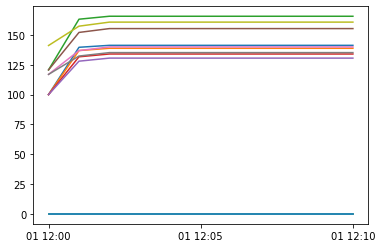

In [19]:
import matplotlib.pyplot as plt
for f in ds_zarr['nface']:
    # print(ds_zarr['volume'].compute().T.shape)
    plt.plot(ds_zarr['time'], ds_zarr['volume'].T[:][f])
plt.show()

In [16]:
ds_zarr

<xarray.Dataset>
Dimensions:                 (time: 11, nedge: 24, 2: 2, nface: 21,
                             nmax_face: 4, node: 16)
Coordinates:
    face_x                  (nface) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    face_y                  (nface) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    node_x                  (node) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    node_y                  (node) float64 dask.array<chunksize=(16,), meta=np.ndarray>
  * time                    (time) datetime64[ns] 2022-01-01T12:00:00 ... 202...
Dimensions without coordinates: nedge, 2, nface, nmax_face, node
Data variables: (12/14)
    advection_coeff         (time, nedge) float64 dask.array<chunksize=(11, 24), meta=np.ndarray>
    diffusion_coeff         (time, nedge) float64 dask.array<chunksize=(11, 24), meta=np.ndarray>
    dt                      (time) timedelta64[ns] dask.array<chunksize=(11,), meta=np.ndarray>
    edge_face_connectivity  (nedge, 2) int32 dask.array<chunksize=(24, 2), meta=np.ndarray>
    edge_length             (nedge) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    edge_nodes              (nedge, 2) int32 dask.array<chunksize=(24, 2), meta=np.ndarray>
    ...                      ...
    face_to_face_dist       (nedge) float64 dask.array<chunksize=(24,), meta=np.ndarray>
    faces_surface_area      (nface) float32 dask.array<chunksize=(21,), meta=np.ndarray>
    mesh2d                  int32 ...
    sum_diffusion_coeff     (time, nface) float64 dask.array<chunksize=(11, 21), meta=np.ndarray>
    vertical_face_area      (time, nedge) float64 dask.array<chunksize=(11, 24), meta=np.ndarray>
    volume                  (time, nface) float64 dask.array<chunksize=(11, 21), meta=np.ndarray>

In [86]:
# ultimately transition this to xarray attributes?
class Params:
    def __init__(self):
        self.diffusion_coefficient = 2
        self.beta = 1

params = Params() 
    

## Sparse Matrix Setup
A sparse matrix is a matrix that is mostly zeroes. Here, we will set up a `NCELL x NCELL` sparse matrix. The diagonal values represent the cell, and then the non-zero values in that row/column represent other cells that share an edge with that cell. The MODFLOW-USG theoretical documentation contains an excellent example of an unstructured grid and the corresponding sparse matrix that can help illustrate this description ([USGS, 2013](https://pubs.usgs.gov/tm/06/a45/pdf/tm6-A45.pdf)) -- see Figures 18 & 19. 

Useful links:
* [Cell Hydraulic Properties](https://www.hec.usace.army.mil/confluence/rasdocs/d2sd/ras2dsedtr/numerical-methods/cell-hydraulic-properties)
* [Face Hydraulic Properties](https://www.hec.usace.army.mil/confluence/rasdocs/d2sd/ras2dsedtr/numerical-methods/face-hydraulic-properties)


First, we will obtain all the data we need to define the left-hand side matrix. We will then convert it to a compressed row sparse matrix format. We can then calculate our right hand side matrix and solve for our concentrations at the n+1 timestep. 

### Left-Hand Side

Because of the functionality of the `csr_matrix` function ([see documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)), we do not need to place each coefficient within the sparse matrix ourselves. Instead, we can define the row/column indices and then some data that should fall within that cell of the sparse matrix. The `scipy` `csr_matrix` function will take care of summing those coefficient values wtihin each cell!  

General items below:
* Do I need to sum on diagonals?
* Advection term:
    * [Upwind Differencing](https://www.youtube.com/watch?v=JVE0fNkc540)
* Leverage numpy operators  
* Check numpy indexing
* Functions to reduce repetition 

The `LHS` class below defines all row/column indices and corresponding data values from the descritized total-load advection-diffusion equation.  

In [87]:
class LHS:
    def __init__(self, ds, params, t):
        '''
        ds: xarray containing all geometry and ouptut results from RAS2D.
            Should follow UGRID conventions.
        params: A class instance containing additional parameters. 
            TBD if this will remain or if parameters will be integrated into xarray.
        t: timestep index  
        '''

        flow_out_indices = np.where(ds['advection_coeff'][t] < 0)[0]
        flow_in_indices = np.where(ds['advection_coeff'][t] > 0)[0]

        # initialize arrays that will define the sparse matrix 
        # rows, cols, data will all have a length of NCONNECTIONS * 2 + NCELL
        # len_val = len(ds['nedge']) * 2 + len(ds['nface']) # update this - can be as long as we need
        len_val = len(ds['nedge']) * 2 + len(ds['nface']) + len(flow_in_indices) + len(flow_out_indices) * 2
        # csr matrix will sum everything as long as we track indices: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

        self.rows = np.zeros(len_val)
        self.cols = np.zeros(len_val)
        self.coef = np.zeros(len_val)
        
    def updateValues(self, ds, params, t):
        ###### diagonal terms - the "A" coefficient in the equations detailed above. 
        start = 0
        end = len(ds['nface'])
        self.rows[start:end] = ds['nface']
        self.cols[start:end] = ds['nface']
        seconds = (ds['dt'].values[t] / np.timedelta64(1, 's'))
        self.coef[start:end] = ds['volume'][t+1] / (seconds * params.beta) + ds['sum_diffusion_coeff'][t]

    
        ###### advection - sometimes on-diagonal, sometimes off-diagonal.
        flow_out_indices = np.where(ds['advection_coeff'][t] < 0)[0]
        flow_in_indices = np.where(ds['advection_coeff'][t] > 0)[0]


        if len(flow_in_indices) > 0:
            # update indices
            start = end
            end = end + len(flow_in_indices)

            # where advection coefficient is positive, the concentration across the face will be the REFERENCE CELL 
            # so the the coefficient will go in the diagonal - both row and column will equal diag_cell
            self.rows[start:end] = ds['edge_face_connectivity'].T[0][flow_in_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[0][flow_in_indices]
            self.coef[start:end] = ds['advection_coeff'][t][flow_in_indices]
        else:
            pass

        if len(flow_out_indices) > 0:

            # update indices
            start = end
            end = end + len(flow_out_indices)

            # where it is negative, the conecentration across the face will be the neighbor cell ("N")
            # so the coefficient will be off diagonal 
            self.rows[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[1][flow_out_indices]
            self.coef[start:end] = ds['advection_coeff'][t][flow_out_indices]

            # update indices and repeat ... does this need to get flipped?
            start = end
            end = end + len(flow_out_indices)

            # where it is negative, the conecentration across the face will be the neighbor cell
            # so the coefficient will be off diagonal 
            self.rows[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[1][flow_out_indices]
            self.coef[start:end] = ds['advection_coeff'][t][flow_out_indices]
        else:
            pass
        
        ###### off-diagonal terms
        f1 = ds['edge_face_connectivity'].T[0]
        f2 = ds['edge_face_connectivity'].T[1]

        # update indices
        start = end
        end = end + len(ds['nedge'])
        self.rows[start:end] = f1
        self.cols[start:end] = f2
        self.coef[start:end] = -1 * ds['diffusion_coeff'][t]

        # update indices and repeat 
        start = end
        end = end + len(ds['nedge'])
        self.rows[start:end] = f1
        self.cols[start:end] = f2
        self.coef[start:end] = -1 * ds['diffusion_coeff'][t]


In [88]:
# test at single timestep
t = 0
lhs = LHS(ds_zarr, params, t)
lhs.updateValues(ds_zarr, params, t)

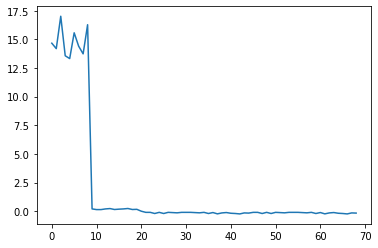

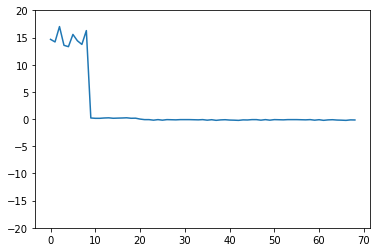

In [89]:
import matplotlib.pyplot as plt
plt.plot(lhs.coef)
plt.show()
plt.plot(lhs.coef)
plt.ylim(-20,20)
plt.show()

### Compressed Sparse Row Matrix

Use the `csr_matrix` function in the `scipy` library to format the left-hand side **A** matrix. 

MODFLOW-USG uses the CSR format for the **A** matrix. All nonzero coefficients in a row of the matrix are stored sequentially, beginning with the first one in the row and ending with the last. The MODFLOW-USG documentation contains some useful details on how these matrices are defined in their [theoretical documentation](https://pubs.usgs.gov/tm/06/a45/pdf/tm6-A45.pdf), starting on page 32. Essentially, it can help with computational efficiency. We are most interested in the ease with which it allows us to set up our sparse matrix. 

In [90]:
A = csr_matrix( (lhs.coef,(lhs.rows, lhs.cols)), shape=(len(ds_zarr['nface']),len(ds_zarr['nface'])))


In [91]:
print(A)
print(A.toarray())
print(A.shape)

  (0, 0)	14.664845485687255
  (0, 1)	-0.20000049591064456
  (0, 3)	-0.20000049591064456
  (0, 9)	-0.4000009918212891
  (0, 17)	-0.4000009918212891
  (1, 1)	14.190797138214112
  (1, 2)	-0.20000049591064456
  (1, 4)	-0.20000049591064456
  (1, 10)	-0.4000009918212891
  (2, 2)	17.017321788980478
  (2, 5)	-0.24141548156738285
  (2, 11)	-0.28285635534290277
  (2, 18)	-0.47280055879969946
  (3, 3)	13.567725601196289
  (3, 6)	-0.20000049591064456
  (3, 13)	-0.4000009918212891
  (4, 3)	-0.20000049591064456
  (4, 4)	13.32161205291748
  (4, 5)	-0.20000049591064456
  (4, 7)	-0.20000049591064456
  (5, 5)	15.572129147367496
  (5, 8)	-0.24141548156738285
  (5, 12)	-0.28285635534290277
  (6, 6)	14.404261725684844
  (6, 7)	-0.23386940002441406
  (6, 14)	-0.4611729116818209
  (6, 19)	-0.298800696853394
  (7, 7)	13.734752940894959
  (7, 8)	-0.23386940002441406
  (7, 15)	-0.298800696853394
  (8, 8)	16.27776422543386
  (8, 16)	-0.3564356097065679
  (8, 20)	-0.3284100866445474
  (9, 9)	0.20000049591064456
 

### Right-Hand Side Vector
The right-hand side vector will be a `NCELL x 1` matrix that stores the total load in the current timestep plus the total load source/sink term (M/T/L2):

$\frac{V_P^{n}C_P^{n}}{\Delta t \beta_P^{n}} + S_PA_P$

* $V_P^{n}$ is the volume at the current timestep. 
* $C_P^{n}$ is the concentration at the current timestep. Provided from solving the previous timestep OR from initial conditions. 
* $ \beta_P^{n}$ and $S_PA_P$ are given? Need to ask more. 


In [177]:
 class RHS:
    def __init__(self, ds, params, t):
        '''
        ds: xarray containing all geometry and ouptut results from RAS2D.
            Should follow UGRID conventions.
        params: A class instance containing additional parameters. 
            TBD if this will remain or if parameters will be integrated into xarray.
        t: timestep index  
        '''
        self.conc = np.zeros(len(ds['nface']))
        self.conc[0] = 146.64845486 # put a concentration in the top left cell to start
        self.vals = np.zeros(len(ds['nface']))

        
    def updateValues(self, ds, params, t):
        # seconds = (ds['dt'].values[t] / np.timedelta64(1, 's'))
        # self.vals[:] = ds['volume'][t] / (seconds * params.beta) * self.conc  # eventually also need to add total-load source/sink term (M/T/L2)
        self.vals= np.repeat(4, len(ds['nface']))
        self.vals[3] = 50
        self.vals[20] = 60

In [178]:
# test at single timestep
t = 0
rhs = RHS(ds_zarr, params, t)
print(rhs.conc)
rhs.updateValues(ds_zarr, params, t)
print(rhs.vals)

[146.64845486   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.        ]
[ 4  4  4 50  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4 60]


In [179]:
# artificially produce solution
# A.dot(b)

In [180]:
dC = spsolve(A,b)

c:\Users\sjordan\Anaconda3\envs\pangeo\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [181]:
b = rhs.vals

In [182]:
dC

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

In [183]:
A

<21x21 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>